In [21]:

# IMPORT NECESSARY LIBRARIES
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
from IPython.display import Audio
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
import keras
from keras.optimizers import SGD
from keras.models import Sequential, Model, model_from_json
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Dense, Embedding, LSTM
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
from keras.utils import to_categorical

In [22]:
# READ IN AUDIO FILES 
audio = "/content/drive/Shareddrives/Research Drive/RAVDESS datasets/"

In [23]:
# READ IN CSV FILE FROM EDA_PREPROCESSING
audio_df=pd.read_csv('/content/drive/Shareddrives/Research Drive/audio.csv',usecols=['emotion','path'])
audio_df.head()

,emotion,path
0,calm,/content/drive/Shareddrives/Research Drive/RAV...
1,calm,/content/drive/Shareddrives/Research Drive/RAV...
2,neutral,/content/drive/Shareddrives/Research Drive/RAV...
3,calm,/content/drive/Shareddrives/Research Drive/RAV...
4,calm,/content/drive/Shareddrives/Research Drive/RAV...


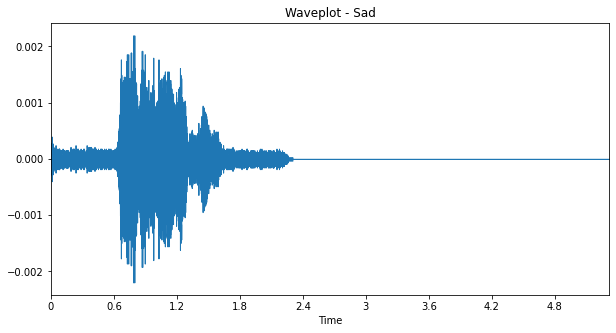

In [24]:

# MALE SAD ORIGINAL AUDIO FILE
fname = audio + '/Actor_09/03-01-04-01-02-02-09.wav'  
x, sr = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Sad')
plt.savefig('Waveplot_Sad.png')

In [25]:
import soundfile as sf
sf.write('/content/drive/Shareddrives/Research Drive/RAVDESS datasets/Actor_09/03-01-04-01-02-02-09.wav', x, sr)
Audio(data=x, rate=sr)

In [26]:

# FUNCTION TO STRETCH THE SOUND
def stretch(x, rate=0.8):
    data = librosa.effects.time_stretch(x, rate)
    return data
    

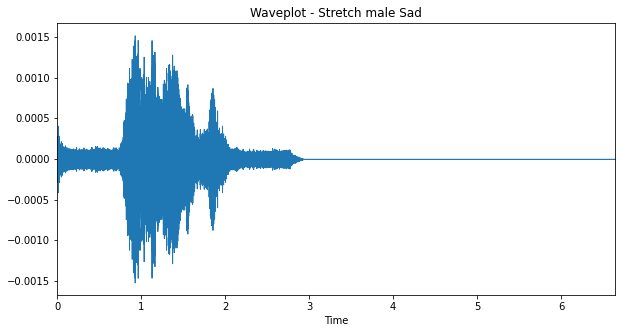

In [27]:

# ADD STRETCH TO MALE SAD ORIGINAL AUDIO FILE
x = stretch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Stretch male Sad')
plt.savefig('Waveplot_MaleSadStretch.png')

In [28]:
# PLAY AUDIO FILE
import soundfile as sf
sf.write('/content/drive/Shareddrives/Research Drive/RAVDESS datasets/Actor_09/03-01-04-01-02-02-09.wav', x, sr)
Audio(data=x, rate=sr)

In [29]:
# FUNCTION TO INCREASE SPEED AND PITCH 
def speedNpitch(x):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.4  / length_change 
    tmp = np.interp(np.arange(0,len(x),speed_fac),np.arange(0,len(x)),x)
    minlen = min(x.shape[0], tmp.shape[0])
    x *= 0
    x[0:minlen] = tmp[0:minlen]
    return x

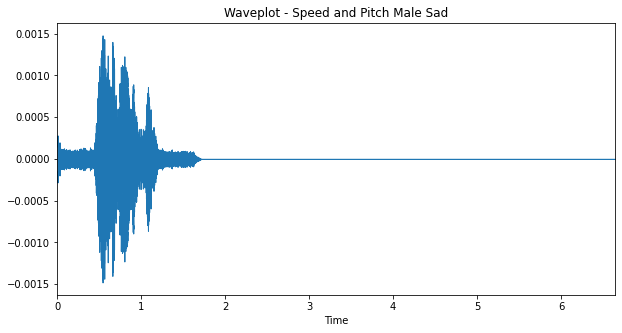

In [30]:
# ADD SPEED AND PITCH TO MALE SAD ORIGINAL AUDIO FILE
x = speedNpitch(x)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(x, sr=sr)
plt.title('Waveplot - Speed and Pitch Male Sad')
plt.savefig('Waveplot_MaleSadSpeedPitch.png')

In [31]:
# PLAY AUDIO FILE
import soundfile as sf
sf.write('/content/drive/Shareddrives/Research Drive/RAVDESS datasets/Actor_09/03-01-04-01-02-02-09.wav', x, sr)
Audio(data=x, rate=sr)

In [32]:
# FEATURE EXTRACTION ON RAW AUDIO FILES
df = pd.DataFrame(columns=['log_spec'])
counter=0

for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    df.loc[counter] = [log_spectrogram]   
    counter += 1
print(len(df))
df.head()

1440


,log_spec
0,"[-80.14738, -80.14738, -80.14738, -80.14738, -..."
1,"[-78.4542, -78.4542, -78.4542, -78.4542, -78.4..."
2,"[-75.15071, -75.15071, -75.15071, -75.15071, -..."
3,"[-79.61142, -79.61142, -79.61142, -79.61142, -..."
4,"[-83.15074, -83.15074, -83.15074, -83.15074, -..."


In [33]:
# ADD SPEED AND PITCH THEN USE FEATURE EXTRACTION
df_speedpitch = pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # speed pitch
    aug = speedNpitch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_speedpitch.loc[counter] = [aug] 
    counter +=1
print(len(df_speedpitch))
df_speedpitch.head()

1440


,feature
0,"[-80.95567, -80.95567, -80.95567, -80.95567, -..."
1,"[-79.63543, -79.63543, -79.63543, -79.63543, -..."
2,"[-75.83633, -75.83633, -75.83633, -75.83633, -..."
3,"[-80.409256, -80.409256, -80.409256, -80.40925..."
4,"[-83.92027, -83.92027, -83.92027, -83.92027, -..."


In [34]:

# ADD STRETCH AND USE FEATURE EXTRACTION ON AUDIO FILES
df_stretch=pd.DataFrame(columns=['feature'])
counter=0
for index,path in enumerate(audio_df.path):
    #get wave representation
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
        # stretch
    aug= stretch(X)
    aug = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000)
    db_spec = librosa.power_to_db(aug)
    aug=np.mean(db_spec,axis=0)
    df_stretch.loc[counter] = [aug] 
    counter +=1
print(len(df_stretch))
df_stretch.head()

1440


,feature
0,"[-80.14738, -80.14738, -80.14738, -80.14738, -..."
1,"[-78.4542, -78.4542, -78.4542, -78.4542, -78.4..."
2,"[-75.15071, -75.15071, -75.15071, -75.15071, -..."
3,"[-79.61142, -79.61142, -79.61142, -79.61142, -..."
4,"[-83.15074, -83.15074, -83.15074, -83.15074, -..."


In [35]:
# ADD CORRESPONDING EMOTION LABELS TO DF['LOG_SPEC']
mfcc_df = pd.DataFrame(df['log_spec'].values.tolist())
labels = audio_df.emotion
mfcc = pd.concat([mfcc_df,labels], axis=1)
mfcc = mfcc.rename(index=str, columns={"0": "label"})

In [36]:

# ADD CORRESPONDING EMOTION LABELS TO DF_SPEEDPITCH['FEATURE']
speedpitch_df = pd.DataFrame(df_speedpitch['feature'].values.tolist())
speedpitch = pd.concat([speedpitch_df,labels], axis=1)
speedpitch = speedpitch.rename(index=str, columns={"0": "label"})

In [37]:
# ADD CORRESPONDING EMOTION LABELS TO DF_STRETCH['FEATURE']
stretch_df = pd.DataFrame(df_stretch['feature'].values.tolist())
stretch = pd.concat([stretch_df,labels], axis=1)
stretch = stretch.rename(index=str, columns={"0": "label"})

In [38]:
# JOIN FOUR DATA FRAMES FOR MODELING
combined_df = pd.concat([mfcc,speedpitch,stretch], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,emotion
0,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.127945,-80.133469,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-80.147377,-79.741898,-79.204338,-79.975922,-80.147377,-80.118141,-80.035789,-79.775558,-79.230133,-80.020821,-80.147377,-80.118446,-79.994080,-80.137436,-79.885605,-79.754646,-79.908585,-78.362213,-75.423454,-75.674515,-78.665031,...,-78.849907,-79.431084,-79.004059,-78.585381,-79.192833,-79.627304,-80.027679,-78.930901,-78.908867,-79.875923,-80.127266,-80.147377,-80.147377,-80.076408,-80.092377,-80.147377,-80.144165,-80.147202,-80.123550,-80.147377,-80.117874,-80.092827,-79.968689,-79.966011,-80.147377,-80.147377,-79.994179,-79.552925,-79.895851,-80.147377,-80.147377,-80.121956,-79.998009,-80.119255,-80.147377,-80.130417,-80.014702,-80.147377,-80.147377,calm
1,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.438843,-78.454201,-78.454201,-78.454201,-78.410423,-78.450684,-78.454201,-78.423790,-78.208931,-78.261787,-78.393005,-78.181946,-76.545563,-77.805222,-78.356667,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.358124,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.454201,-78.303322,-77.402367,-76.721939,-74.789162,-73.571297,...,-77.959778,-77.530724,-77.818649,-78.392990,-78.245819,-78.109596,-77.947098,-77.856438,-78.035370,-77.977028,-78.129005,-78.303757,-78.454201,-78.370880,-78.163841,-78.345741,-78.445099,-78.454201,-78.454201,-78.364929,-78.218132,-78.112137,-78.430374,-78.454201,-78.053932,-77.932953,-78.429512,-78.454201,-78.211533,-78.155396,-78.425537,-78.454201,-78.454201,-78.454201,-78.441124,-78.454201,0.000000,0.000000,0.000000,calm
2,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.139587,-75.072227,-75.150711,-75.150711,-75.150711,-75.150711,-75.099373,-75.150711,-75.150711,-75.150711,-75.109047,-75.094116,-75.150711,-74.928223,-74.151703,-74.198418,-74.515488,-75.119537,-75.103989,-75.131653,-75.150711,-75.150711,-75.149879,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.069016,-74.121017,-73.617714,-74.536026,-74.173920,...,-75.150711,-75.150711,-75.150711,-75.150711,-75.112236,-75.101410,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-75.150711,-74.863907,-74.294701,-74.354446,-74.683067,-74.923653,-74.444016,-74.158699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,neutral
3,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.610367,-79.611420,-79.550499,-79.398399,-79.582024,-79.611420,-79.611420,-79.602898,-79.609360,-79.611420,-79.610100,-79.575806,-79.363792,-79.245369,-79.572586,-79.611420,-79.104889,-78.065300,-78.346611,-79.328812,-79.611420,-79.380302,-76.994888,-69.494263,-67.420494,-71.692848,-77.551788,-78.594078,-77.331970,-76.804787,-75.728836,-73.673401,-73.638512,...,-78.320374,-79.211922,-79.385170,-79.452354,-79.595520,-79.334435,-79.189003,-79.421410,-79.542503,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.424179,-79.310196,-79.611420,-79.555916,-79.548904,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.611420,-79.595421,-79.611420,-79.611420,-79.611420,-79.611420,calm
4,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.150742,-83.136513,-83.108086,-83.150742,-83.150742,-83.141273,-82.372421,-82.121544,-81.688293,-80.642906,-81.102776,-80.855865,-81.771767,-82.979225,-82.591644,-82.889153,

In [39]:
combined_df.shape

(4320, 260)

In [40]:
mfcc.shape

(1440, 260)

In [41]:

speedpitch.shape

(1440, 260)

In [42]:
stretch.shape

(1440, 260)

In [43]:

# STRATIFIED SHUFFLE SPLIT TO HANDLE CLASS IMBALANCE
X = combined_df.drop(['emotion'], axis=1)
y = combined_df.emotion
xxx = StratifiedShuffleSplit(1, test_size=0.25, random_state=12)
for train_index, test_index in xxx.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [44]:

y_train.value_counts()

calm        432
fear        432
sad         432
surprise    432
angry       432
happy       432
disgust     432
neutral     216
Name: emotion, dtype: int64

In [45]:
y_test.value_counts()

calm        144
surprise    144
fear        144
disgust     144
angry       144
sad         144
happy       144
neutral      72
Name: emotion, dtype: int64

In [46]:
# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [47]:
# TURN INTO ARRAYS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [48]:
# ONE HOT ENCODE EMOTION LABELS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))

print(y_test[0:10])

[[0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0.]]


In [49]:

print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [50]:
# RESHAPE TO ADD 3D TENSOR FOR 1D CNN INPUT
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]
X_test.shape

(1080, 259, 1)

In [56]:

# BUILD 1D CNN LAYERS
model = Sequential()
model.add(Conv1D(64, kernel_size=(20), activation='relu', input_shape=(X_train.shape[1],1)))
model.add(Conv1D(128, kernel_size=(20),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Conv1D(128, kernel_size=(20),activation='relu'))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))
model.summary()
opt = SGD(lr = 0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#opt = keras.optimizers.Adam(lr=0.0001)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 240, 64)           1344      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 221, 128)          163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 128)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 27, 128)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 8, 128)            327808    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)           

In [65]:
# FIT MODEL
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train,batch_size=16, epochs=500, validation_data=(X_test, y_test))

Epoch 1/500
203/203 [==============================] - 2s 7ms/step - loss: 0.3970 - accuracy: 0.8803 - val_loss: 0.8427 - val_accuracy: 0.7787
Epoch 2/500
203/203 [==============================] - 1s 6ms/step - loss: 0.3675 - accuracy: 0.8926 - val_loss: 0.8605 - val_accuracy: 0.7750
Epoch 3/500
203/203 [==============================] - 1s 6ms/step - loss: 0.3942 - accuracy: 0.8796 - val_loss: 0.8488 - val_accuracy: 0.7824
Epoch 4/500
203/203 [==============================] - 1s 6ms/step - loss: 0.3820 - accuracy: 0.8860 - val_loss: 0.8592 - val_accuracy: 0.7722
Epoch 5/500
203/203 [==============================] - 1s 6ms/step - loss: 0.3722 - accuracy: 0.8898 - val_loss: 0.8537 - val_accuracy: 0.7750
Epoch 6/500
203/203 [==============================] - 1s 6ms/step - loss: 0.3922 - accuracy: 0.8843 - val_loss: 0.8416 - val_accuracy: 0.7778
Epoch 7/500
203/203 [==============================] - 1s 6ms/step - loss: 0.3916 - accuracy: 0.8874 - val_loss: 0.8501 - val_accuracy: 0.7824

In [66]:
#model.save_weights("best_model_weights.h5")
#model.save('best_model.h5')
#print("Saved model to disk")

Saved model to disk


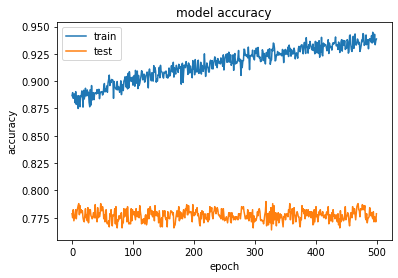

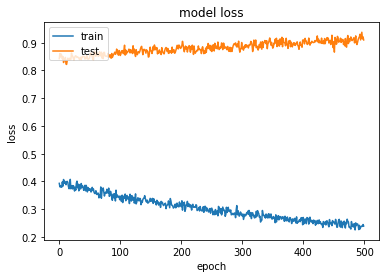

In [67]:
# PRINT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Augmented_Model_Loss.png')
plt.show()

In [62]:

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions})

# ACTUAL LABELS
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'Actual Values': actual})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = actual.join(predictions)
finaldf[140:150]

,Actual Values,Predicted Values
140,disgust,disgust
141,happy,happy
142,neutral,neutral
143,angry,angry
144,neutral,neutral
145,neutral,calm
146,happy,happy
147,sad,sad
148,neutral,calm
149,calm,calm


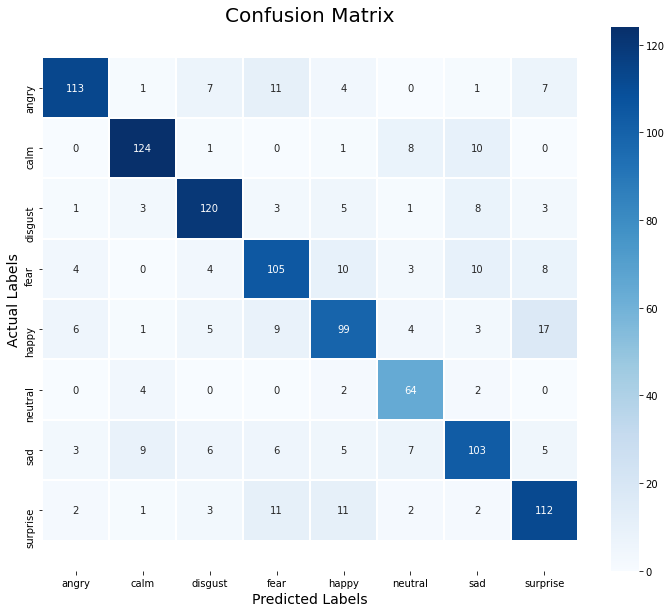

In [63]:

# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Augmented_Model_Confusion_Matrix.png')
plt.show()

In [64]:
from sklearn.metrics import classification_report
print(classification_report(actual, predictions, target_names = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']))

              precision    recall  f1-score   support

       angry       0.88      0.78      0.83       144
        calm       0.87      0.86      0.86       144
     disgust       0.82      0.83      0.83       144
        fear       0.72      0.73      0.73       144
       happy       0.72      0.69      0.70       144
     neutral       0.72      0.89      0.80        72
         sad       0.74      0.72      0.73       144
    surprise       0.74      0.78      0.76       144

    accuracy                           0.78      1080
   macro avg       0.78      0.78      0.78      1080
weighted avg       0.78      0.78      0.78      1080

